# Training pipeline: Multi-layer perceptron implementation

Now we are going to build off our previous code with a data pipeline and a MLP and add training so that we can update our weights and biases using backpropogation, with a hope of minimising our MSE and making better predictions!

Remember that an MLP with a single hidden layer might look something like this:

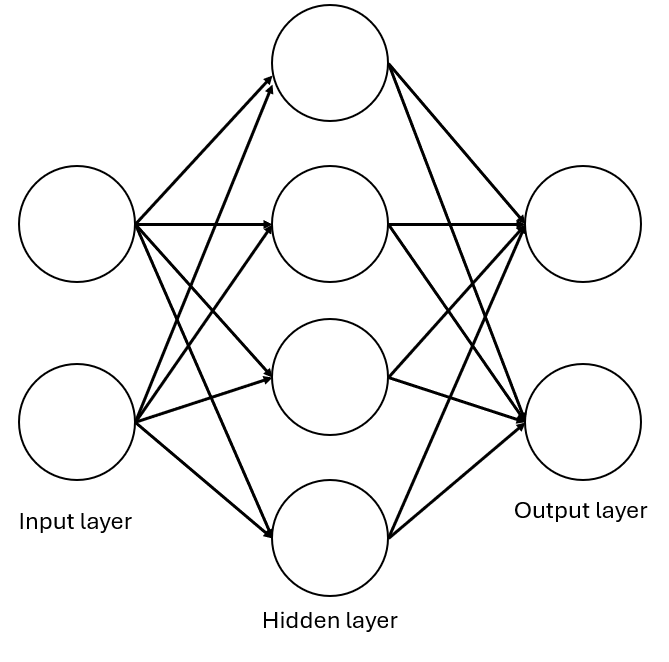

*Note*: in practise your MLP can be as deep (i.e. number of hidden layers) and as wide (i.e. number of neurons in a hidden layer) as we want but for our purposes (and to make it quick to train), a single hidden layer will be sufficient!

The three main components of an MLP are:
1. The Input layer: where each neuron represents a feature (e.g. petal length). This layer passes data forward without performing computation.
2. The Hidden layer(s): The core of the neural network. Neurons in the hidden layers:
    - Receive inputs from all previous-layer neurons (fully connected)
    - Apply a weighted sum and a non-linear activation function (like ReLU)
    - Learn by updating weights during training (using backpropogation which we'll learn about later)
3. The Output layer: Generates the prediction. For classification tasks like the Iris dataset, each neuron can represent a class (e.g. setosa, versicolor, virginica).

## Step 1: Define the MLP model

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialise a simple feedforward MLP architecture.
        
        Parameters:
         input_size: Number of input features (e.g., 4 for Iris dataset)
         hidden_size: Number of neurons in the hidden layer
         num_classes: Number of output classes (e.g., 3 for Iris species)
        """
        super(MLP, self).__init__()
        
        # First layer (input to hidden)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        
        # Second layer (hidden to hidden)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        
        # Output layer (hidden to output)
        self.output = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification
        
    def forward(self, x):
        """
        Define the forward pass through the network for a single input.
        
        Parameter:
         x: Input tensor of shape [input_size] representing a single sample
        
        Returns:
         Output tensor of shape [num_classes] for a single prediction
        """

        # Forward pass through the network
        # Each step applies a linear transformation followed by a non-linear activation
        
        x = self.layer1(x)
        x = self.relu(x)
            
        x = self.layer2(x)
        x = self.relu(x)
            
        x = self.output(x)
        x = self.softmax(x)  # Apply softmax to get probabilities
        
        return x

## Step 2: Set model parameters and initialise model

In [ ]:
input_size = 4    # Assuming 4 features (like Iris dataset)
hidden_size = 16  # Neurons in hidden layer
num_classes = 3   # Output classes 
model = MLP(input_size, hidden_size, num_classes)
model

## Step 3: Prepare Iris Test Dataset

In [ ]:
# In this step, the process is identical to the data handling steps in "DataPipeline" notebook.
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler


# load the dataset
iris = load_iris()


# extract features and target classes
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# standardise the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


batch_size = 30
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Step 4: Evaluate Test Loss and Accuracy


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Initialize a list to store the individual losses
losses = []

# Evaluate the average MSE loss of the model on the test_dataset
model.eval()
total_test_loss = 0
num_test_samples = 0

with torch.no_grad():
    for features, labels in test_loader:
        for i in range(features.size(0)):
            # Extract individual feature and label

            # The unsqueeze(0) adds a batch dimension to the one-hot encoded label, 
            # making it compatible with the model's output shape.

            single_feature = features[i].unsqueeze(0)  # Add batch dimension
            single_label = labels[i]

            # Forward pass
            prediction = model(single_feature)

            # The one-hot encoding converts the class label into a vector with only 0s and 1s.
            # For example, if the class label is 1 for the second class in a 3-class problem,
            # the one-hot encoding would be [0, 1, 0].

            # One-hot encode label and convert to float
            one_hot_label = F.one_hot(single_label, num_classes=3).float().unsqueeze(0)

            # Calculate MSE loss
            loss = F.mse_loss(prediction, one_hot_label)

            losses.append(loss.item())
            total_test_loss += loss.item()
            num_test_samples += 1

# Calculate average loss across all processed samples
if num_test_samples > 0:
    avg_test_loss = total_test_loss / num_test_samples
    print(f"\nAverage MSE loss on test set ({num_test_samples} samples): {avg_test_loss:.4f}")

    # Plot the losses as a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_test_samples), losses, label='Sample-wise MSE Loss', color='tab:blue', linewidth=2)
    plt.xlabel("Sample Index")
    plt.ylabel("MSE Loss")
    plt.title("MSE Loss per Sample on Test Set")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Step 5: Implement Training Pipeline

### Setting the learning Rate

Ineuralep network trainingsettingng the learning rate over time is beneficial. With high learning rates, parameter vectors bounce chaotically, struggling to settle into optimal regions of the loss function. The timing of decay is crucial; too slow wastes computation, too fast prevents finding the best solution. The code below `optim.SGD(model.parameters(), lr=Learning_rate)` creates a [Stochastic Gradient Descent optimiser](https://optimization.cbe.cornell.edu/index.php?title=Stochastic_gradient_descent) that will adjust the parameters of our model during training. It configures the optimiser to work with all the parameters in our model and sets an initial learning rate. This optimiser SGD is responsible for updating our model's weights based on the calculated gradients, helping the model to improve over time during the training process.er training.

In [ ]:
import torch.optim as optim

Learning_rate = 0.1
# Set up optimiser which in our case is Stochastic Gradient Descent
optimiser = optim.SGD(model.parameters(), lr=Learning_rate)

# nn.Module has a built in method called .parameters() which returns the model's parameters
# Related batches to learning rate

As an exercise, you can try varying the learning rate and seeing how the test loss curve changes. More on fine tuning the learning rate is in the next section!

### Choosing number of epochs
Determining the optimal [number of epochs](https://deepai.org/machine-learning-glossary-and-terms/epoch) is crucial for neural network design. Too few, and our model will not learn properly; too many, and it may overfit, learning data noise rather than useful patterns. The right number is typically found through experimentation and monitoring performance on a validation set. You can also sometimes set the training to stop early if you reach a certain MSE threshold.

In [ ]:
# What is an epoch? One run of all the batches. 

num_epochs = 100

As an exercise, you can try increasing or decreasing the number of epochs to analyse how it affects our training. 

In [ ]:
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    
    ### TRAINING PHASE
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(features)

        # One-hot encode labels and convert to float
        one_hot = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1).float()
        loss = F.mse_loss(outputs, one_hot)  # MSE loss

        loss.backward()
        optimiser.step()
        total_loss += loss.item() * features.size(0)  # Multiply by batch size to undo mean

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    ### TESTING PHASE
    model.eval()
    test_total_loss = 0

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            one_hot = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1).float()
            test_loss = F.mse_loss(outputs, one_hot)
            test_total_loss += test_loss.item() * features.size(0)  # Accumulate total

    avg_test_loss = test_total_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot training and testing loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title(f"Training and Testing Loss Curves, Epochs: {num_epochs}, Learning Rate: {Learning_rate}")
plt.legend()
plt.grid(True)
plt.show()


With small datasets (like Iris), the variance between train and test splits can lead to test loss being lower by chance — particularly if the test set is slightly easier to model.

For classification problems it's good practise to visualise a confusion matrix to see how well our classifier predicts each class. We are using a very small, clean dataset here so it's not surprising that our MLP performs very well.

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions for the test set
y_pred = []
with torch.no_grad():
    for features, _ in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        y_pred.extend(predicted.numpy())
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()